# ResNet

## Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

## Plain Networks

### Conv block

In [2]:
def conv_batch(layer, channel, kernel_size, padding='same', strides=1, activation='relu', name='0'):
    x = keras.layers.Conv2D(filters=channel,
                            kernel_size=kernel_size,
                            kernel_initializer='he_normal',
                            padding=padding,
                            strides=strides,
                            name=f'conv_{name}')(layer)
    x = keras.layers.BatchNormalization(name=f'batch_{name}')(x)
    if activation:
        x = keras.layers.Activation(activation, name=f'act_{name}')(x)
    
    return x

### Plain block 

In [3]:
def build_plain_block(input_layer, block_num=0, num_cnn=3, channel=64, is_50=True):
    x = input_layer
    
    # plain_50
    if is_50:
        for i in range(num_cnn):
            if block_num > 0 and i==0:
                x = conv_batch(x, channel, (1,1), strides=2, name=f'{block_num}_{i}1')
                x = conv_batch(x, channel, (3,3), name=f'{block_num}_{i}2')
                x = conv_batch(x, channel*4, (1,1), name=f'{block_num}_{i}3')
            else:
                x = conv_batch(x, channel, (1,1), name=f'{block_num}_{i}1')
                x = conv_batch(x, channel, (3,3), name=f'{block_num}_{i}2')
                x = conv_batch(x, channel*4, (1,1), name=f'{block_num}_{i}3')
    # plain_34
    else:
        for i in range(num_cnn):
            if block_num > 0 and i==0:
                x = conv_batch(x, channel, (3,3), strides=2, name=f'{block_num}_{i}1')
                x = conv_batch(x, channel, (3,3), name=f'{block_num}_{i}2')
            else:
                x = conv_batch(x, channel, (3,3), name=f'{block_num}_{i}1')
                x = conv_batch(x, channel, (3,3), name=f'{block_num}_{i}2')

    return x

###  Build plain network

In [4]:
 def build_plain(num_cnn_list, channel_list, is_50=True, input_shape=(32,32,3), num_classes=10, name='Plain_50'):
    
    assert len(num_cnn_list) == len(channel_list)
    
    input_layer = keras.layers.Input(shape=input_shape, name='Input')
    
    # first layer
    conv1 = conv_batch(input_layer, 64, (7,7), strides=2, name='first')
    plain = keras.layers.MaxPool2D(pool_size=(2,2), strides=2, name='maxpool_first')(conv1)
    
    # plain block
    for block_num, (cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        plain = build_plain_block(plain, block_num, cnn, channel, is_50)
    
    gap = keras.layers.GlobalAveragePooling2D(name='GAP')(plain)
    output = keras.layers.Dense(num_classes, activation='softmax', name='FC')(gap)
    
    model = keras.Model(inputs=input_layer, outputs=output, name=name)
    
    return model


### Plain-34

In [5]:
plain_34 = build_plain(num_cnn_list=[3, 4, 6, 3],
                       channel_list=[64, 128, 256, 512],
                       is_50=False,
                       input_shape=(224,224,3),
                       name='Plain_34')
plain_34.summary()

Model: "Plain_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv_first (Conv2D)          (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_first (BatchNormalizat (None, 112, 112, 64)      256       
_________________________________________________________________
act_first (Activation)       (None, 112, 112, 64)      0         
_________________________________________________________________
maxpool_first (MaxPooling2D) (None, 56, 56, 64)        0         
_________________________________________________________________
conv_0_01 (Conv2D)           (None, 56, 56, 64)        36928     
_________________________________________________________________
batch_0_01 (BatchNormalizati (None, 56, 56, 64)        256

### Plain-50

In [6]:
plain_50 = build_plain(num_cnn_list = [3, 4, 6, 3],
                       channel_list=[64, 128, 256, 512],
                       is_50=True,
                       input_shape=(224,224,3))
plain_50.summary()

Model: "Plain_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv_first (Conv2D)          (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_first (BatchNormalizat (None, 112, 112, 64)      256       
_________________________________________________________________
act_first (Activation)       (None, 112, 112, 64)      0         
_________________________________________________________________
maxpool_first (MaxPooling2D) (None, 56, 56, 64)        0         
_________________________________________________________________
conv_0_01 (Conv2D)           (None, 56, 56, 64)        4160      
_________________________________________________________________
batch_0_01 (BatchNormalizati (None, 56, 56, 64)        256

## ResNet

### Residual block

In [7]:
def build_residual_block(input_layer, block_num=0, num_cnn=3, channel=64, is_50=True):
    x = input_layer
    
    # ResNet 50
    if is_50:
        for i in range(num_cnn):
            if i==0:
                shortcut = conv_batch(x, channel*4, (1,1), strides=2, activation=None, name=f'_shortcut_{block_num}_{i}')
                x = conv_batch(x, channel, (1,1), strides=2, name=f'{block_num}_{i}1')
                x = conv_batch(x, channel, (3,3), name=f'{block_num}_{i}2')
                x = conv_batch(x, channel*4, (1,1), activation=None, name=f'{block_num}_{i}3')
            else:
                shortcut = x
                x = conv_batch(x, channel, (1,1), name=f'{block_num}_{i}1')
                x = conv_batch(x, channel, (3,3), name=f'{block_num}_{i}2')
                x = conv_batch(x, channel*4, (1,1), activation=None, name=f'{block_num}_{i}3')
            
            x = keras.layers.Add(name=f'shortcut_add_{block_num}_{i}')([x, shortcut])
            x = keras.layers.Activation('relu', name=f'shortcut_act_{block_num}_{i}')(x)
    # ResNet 34
    else:
        for i in range(num_cnn):
            if block_num > 0 and i==0:
                shortcut = conv_batch(x, channel, (1,1), strides=2, activation=None, name=f'_shortcut_{block_num}_{i}')
                x = conv_batch(x, channel, (3,3), strides=2, name=f'{block_num}_{i}1')
                x = conv_batch(x, channel, (3,3), activation=None, name=f'{block_num}_{i}2')
            else:
                shortcut = x
                x = conv_batch(x, channel, (3,3), name=f'{block_num}_{i}1')
                x = conv_batch(x, channel, (3,3), activation=None, name=f'{block_num}_{i}2')
            
            x = keras.layers.Add(name=f'shortcut_add_{block_num}_{i}')([x, shortcut])
            x = keras.layers.Activation('relu', name=f'shortcut_act_{block_num}_{i}')(x)
    

    return x

### Build ResNet

In [8]:
def build_resnet(num_cnn_list, channel_list, is_50=True, input_shape=(32,32,3), num_classes=10, name='ResNet_50'):
    
    assert len(num_cnn_list) == len(channel_list)
    
    input_layer = keras.layers.Input(shape=input_shape, name='Input')
    
    # first layer
    conv1 = conv_batch(input_layer, 64, (7,7), strides=2, name='first')
    res = keras.layers.MaxPool2D(pool_size=(2,2), strides=2, name='maxpool_first')(conv1)
    
    # Residual block
    for block_num, (cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        res = build_residual_block(res, block_num, cnn, channel, is_50)
        
    gap = keras.layers.GlobalAveragePooling2D(name='GAP')(res)
    output = keras.layers.Dense(num_classes, activation='softmax', name='FC')(gap)
    
    model = keras.Model(inputs=input_layer, outputs=output, name=name)
    return model

### ResNet-34

In [9]:
resnet_34 = build_resnet(num_cnn_list = [3, 4, 6, 3],
                         channel_list=[64, 128, 256, 512],
                         is_50=False,
                         input_shape=(224,224,3),
                         name='ResNet_34')
resnet_34.summary()

Model: "ResNet_34"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv_first (Conv2D)             (None, 112, 112, 64) 9472        Input[0][0]                      
__________________________________________________________________________________________________
batch_first (BatchNormalization (None, 112, 112, 64) 256         conv_first[0][0]                 
__________________________________________________________________________________________________
act_first (Activation)          (None, 112, 112, 64) 0           batch_first[0][0]                
__________________________________________________________________________________________

### ResNet-50

In [10]:
resnet_50 = build_resnet(num_cnn_list = [3, 4, 6, 3],
                         channel_list=[64, 128, 256, 512],
                         is_50=True,
                         input_shape=(224,224,3))
resnet_50.summary()

Model: "ResNet_50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv_first (Conv2D)             (None, 112, 112, 64) 9472        Input[0][0]                      
__________________________________________________________________________________________________
batch_first (BatchNormalization (None, 112, 112, 64) 256         conv_first[0][0]                 
__________________________________________________________________________________________________
act_first (Activation)          (None, 112, 112, 64) 0           batch_first[0][0]                
__________________________________________________________________________________________

## ResNet-34 vs ResNet-50 vs Plain-34 vs Plain-50

### Dataset (cats_and_dog)

In [11]:
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:90%]', 'train[90%:]'],
    shuffle_files=True,
    with_info=True,
)

In [12]:
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [13]:
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(20936, shape=(), dtype=int64)
tf.Tensor(2326, shape=(), dtype=int64)


In [14]:
def normalize_and_resize_img(image, label):
    image = tf.cast(image, tf.float32) / 255.
    image = tf.image.resize(image, (224,224)) # CIFAR-10 resize
    return image, label

In [15]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

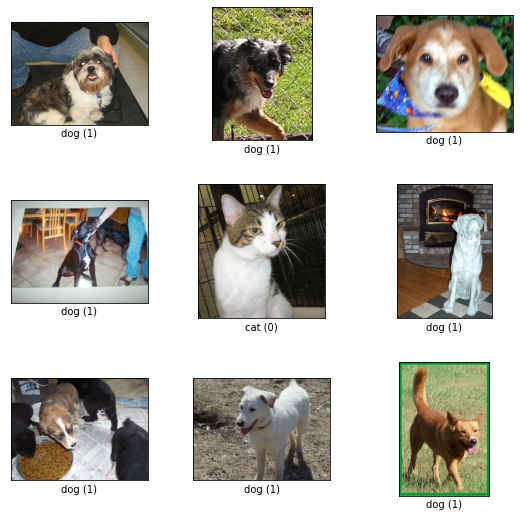

In [16]:
fig = tfds.show_examples(ds_train, ds_info)

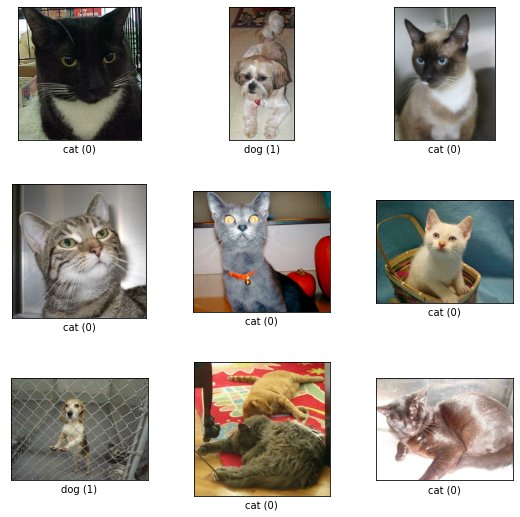

In [17]:
fig = tfds.show_examples(ds_test, ds_info)

### Train

In [18]:
BATCH_SIZE = 32 #256
iteration = 15000 #600000
EPOCH = iteration*BATCH_SIZE//int(ds_info.splits['train'].num_examples)

In [19]:
EPOCH

20

In [20]:
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:90%]', 'train[90%:]'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [21]:
def scheduler(epoch, lr):
    if epoch == EPOCH//2:
        lr *=0.1
    elif epoch == (EPOCH//4)*3:
        lr *=0.1
    return lr

In [22]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5, verbose=1)
# lr_scheduler = keras.callbacks.LearningRateScheduler(scheduler)

In [24]:
resnet_34 = build_resnet(num_cnn_list = [3, 4, 6, 3],
                         channel_list=[64, 128, 256, 512],
                         is_50=False,
                         input_shape=(224,224,3),
                         num_classes=2,
                         name='ResNet_34')

In [25]:
resnet_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.1, decay=1e-4, momentum=0.9, clipnorm=1.),
    metrics=['accuracy'],
)

history_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:90%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[90%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    callbacks=[lr_scheduler],
    use_multiprocessing=True,
)

Epoch 1/20
654/654 [==============================] - 118s 180ms/step - loss: 0.7966 - accuracy: 0.5490 - val_loss: 0.6956 - val_accuracy: 0.5292
Epoch 2/20
654/654 [==============================] - 124s 190ms/step - loss: 0.6545 - accuracy: 0.6134 - val_loss: 0.7022 - val_accuracy: 0.5868
Epoch 3/20
654/654 [==============================] - 112s 171ms/step - loss: 0.6210 - accuracy: 0.6574 - val_loss: 0.6175 - val_accuracy: 0.6411
Epoch 4/20
654/654 [==============================] - 112s 171ms/step - loss: 0.5713 - accuracy: 0.6984 - val_loss: 0.6077 - val_accuracy: 0.6905
Epoch 5/20
654/654 [==============================] - 112s 171ms/step - loss: 0.5258 - accuracy: 0.7364 - val_loss: 0.7595 - val_accuracy: 0.5972
Epoch 6/20
654/654 [==============================] - 112s 171ms/step - loss: 0.4912 - accuracy: 0.7639 - val_loss: 0.6126 - val_accuracy: 0.7044
Epoch 7/20
654/654 [==============================] - 112s 171ms/step - loss: 0.4456 - accuracy: 0.7890 - val_loss: 0.4230 -

In [26]:
resnet_50 = build_resnet(num_cnn_list = [3, 4, 6, 3],
                         channel_list=[64, 128, 256, 512],
                         is_50=True,
                         input_shape=(224,224,3),
                         num_classes=2)

In [28]:
resnet_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.1, decay=1e-4, momentum=0.9, clipnorm=1.),
    metrics=['accuracy'],
)

history_50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:90%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[90%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    callbacks=[lr_scheduler],
    use_multiprocessing=True,
)

Epoch 1/20
654/654 [==============================] - 95s 145ms/step - loss: 0.9749 - accuracy: 0.5275 - val_loss: 0.6929 - val_accuracy: 0.5715
Epoch 2/20
654/654 [==============================] - 117s 178ms/step - loss: 0.6572 - accuracy: 0.6126 - val_loss: 0.6984 - val_accuracy: 0.5785
Epoch 3/20
654/654 [==============================] - 81s 123ms/step - loss: 0.5971 - accuracy: 0.6849 - val_loss: 0.7725 - val_accuracy: 0.6282
Epoch 4/20
654/654 [==============================] - 81s 123ms/step - loss: 0.5467 - accuracy: 0.7232 - val_loss: 1.0936 - val_accuracy: 0.5677
Epoch 5/20
654/654 [==============================] - 80s 123ms/step - loss: 0.5088 - accuracy: 0.7513 - val_loss: 0.5215 - val_accuracy: 0.7398
Epoch 6/20
654/654 [==============================] - 81s 124ms/step - loss: 0.4680 - accuracy: 0.7783 - val_loss: 0.7683 - val_accuracy: 0.7572
Epoch 7/20
654/654 [==============================] - 81s 123ms/step - loss: 0.4278 - accuracy: 0.8030 - val_loss: 1.1087 - val_a

In [29]:
plain_34 = build_plain(num_cnn_list=[3, 4, 6, 3],
                       channel_list=[64, 128, 256, 512],
                       is_50=False,
                       input_shape=(224,224,3),
                       num_classes=2,
                       name='Plain_34')

In [30]:
plain_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.1, decay=1e-4, momentum=0.9, clipnorm=1.),
    metrics=['accuracy'],
)

history_plain_34 = plain_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:90%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[90%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    callbacks=[lr_scheduler],
    use_multiprocessing=True,
)

Epoch 1/20
654/654 [==============================] - 106s 162ms/step - loss: 0.7132 - accuracy: 0.5204 - val_loss: 0.7071 - val_accuracy: 0.5096
Epoch 2/20
654/654 [==============================] - 106s 162ms/step - loss: 0.6770 - accuracy: 0.5724 - val_loss: 0.6508 - val_accuracy: 0.6216
Epoch 3/20
654/654 [==============================] - 106s 162ms/step - loss: 0.6574 - accuracy: 0.6210 - val_loss: 0.6514 - val_accuracy: 0.6378
Epoch 4/20
654/654 [==============================] - 106s 162ms/step - loss: 0.6419 - accuracy: 0.6378 - val_loss: 0.7467 - val_accuracy: 0.5907
Epoch 5/20
654/654 [==============================] - 106s 162ms/step - loss: 0.6204 - accuracy: 0.6590 - val_loss: 0.6811 - val_accuracy: 0.6202
Epoch 6/20
654/654 [==============================] - 106s 162ms/step - loss: 0.5979 - accuracy: 0.6844 - val_loss: 1.0657 - val_accuracy: 0.5495
Epoch 7/20
654/654 [==============================] - ETA: 0s - loss: 0.5753 - accuracy: 0.7029
Epoch 00007: ReduceLROnPlate

In [31]:
plain_50 = build_plain(num_cnn_list = [3, 4, 6, 3],
                       channel_list=[64, 128, 256, 512],
                       is_50=True,
                       input_shape=(224,224,3),
                       num_classes=2)

In [32]:
plain_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.1, decay=1e-4, momentum=0.9, clipnorm=1.),
    metrics=['accuracy'],
)

history_plain_50 = plain_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:90%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[90%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    callbacks=[lr_scheduler],
    use_multiprocessing=True,
)

Epoch 1/20
654/654 [==============================] - 178s 272ms/step - loss: 0.7716 - accuracy: 0.5059 - val_loss: 0.6912 - val_accuracy: 0.5174
Epoch 2/20
654/654 [==============================] - 193s 295ms/step - loss: 0.6957 - accuracy: 0.5140 - val_loss: 0.6940 - val_accuracy: 0.5026
Epoch 3/20
654/654 [==============================] - 168s 257ms/step - loss: 0.6940 - accuracy: 0.5212 - val_loss: 0.6888 - val_accuracy: 0.5578
Epoch 4/20
654/654 [==============================] - 168s 257ms/step - loss: 0.6916 - accuracy: 0.5303 - val_loss: 0.6871 - val_accuracy: 0.5386
Epoch 5/20
654/654 [==============================] - 168s 257ms/step - loss: 0.6865 - accuracy: 0.5480 - val_loss: 0.6904 - val_accuracy: 0.5438
Epoch 6/20
654/654 [==============================] - 168s 257ms/step - loss: 0.6852 - accuracy: 0.5513 - val_loss: 0.6827 - val_accuracy: 0.5702
Epoch 7/20
654/654 [==============================] - 168s 256ms/step - loss: 0.6829 - accuracy: 0.5622 - val_loss: 0.7046 -

### Comparison

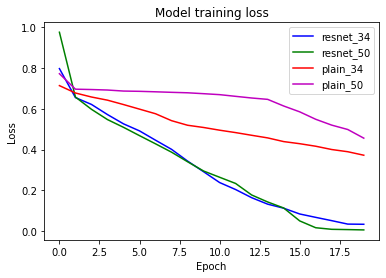

In [33]:
plt.plot(history_34.history['loss'], 'b')
plt.plot(history_50.history['loss'], 'g')
plt.plot(history_plain_34.history['loss'], 'r')
plt.plot(history_plain_50.history['loss'], 'm')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'resnet_50', 'plain_34', 'plain_50'], loc='upper right')
plt.show()

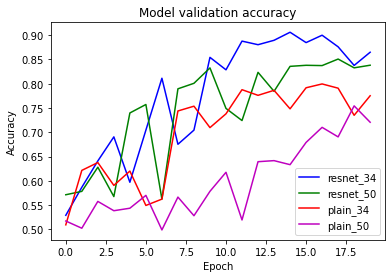

In [34]:
plt.plot(history_34.history['val_accuracy'], 'b')
plt.plot(history_50.history['val_accuracy'], 'g')
plt.plot(history_plain_34.history['val_accuracy'], 'r')
plt.plot(history_plain_50.history['val_accuracy'], 'm')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'resnet_50', 'plain_34', 'plain_50'], loc='lower right')
plt.show()